In [12]:
import sys 
sys.path.append("/mnt/shared/users/wessim.omezzine/hip-analysis")
from hip.analysis.aoi import AnalysisArea
from hip.analysis.data._datasources import DATASOURCE_CONFIGS
import os
import dask
from dask.distributed import Client, progress
import rioxarray as rxr
import glob
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime


import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import rasterio

import warnings
warnings.filterwarnings("ignore")

import s3fs
import xarray as xr
import dask
# Create a dask client to distribute (speed up) the coputation

# if dashboard.link set to default value and running behind hub, make dashboard link go via proxy
if dask.config.get("distributed.dashboard.link") == '{scheme}://{host}:{port}/status':
    jup_prefix = os.environ.get('JUPYTERHUB_SERVICE_PREFIX')
    if jup_prefix is not None:
        jup_prefix = jup_prefix.rstrip('/')
        dask.config.set({"distributed.dashboard.link": f"{jup_prefix}/proxy/{{port}}/status"})

client = Client()
client

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35527
INFO:distributed.scheduler:  dashboard at:  /user/wessim.omezzine/proxy/35249/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35255'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39997'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37141'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42729'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:42091', name: 3, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42091
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:34672
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33999', name: 2, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33999
INFO:distributed.core:

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/wessim.omezzine/proxy/35249/status,
Dashboard: /user/wessim.omezzine/proxy/35249/status,Workers: 4
Total threads: 4,Total memory: 15.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35527,Workers: 4
Dashboard: /user/wessim.omezzine/proxy/35249/status,Total threads: 4
Started: Just now,Total memory: 15.20 GiB
Comm: tcp://127.0.0.1:33605,Total threads: 1
Dashboard: /user/wessim.omezzine/proxy/40355/status,Memory: 3.80 GiB
Nanny: tcp://127.0.0.1:35255,


In [13]:
region="Indonesia2"
start_season =2
end_season =7

bbox = (110.214844,-2.416276,116.037598,1.515936) 
area = AnalysisArea(
    bbox=bbox,
    datetime_range="1983-01-01/2023-06-30"  # change the starting date 1983  
)

In [14]:

r1h = area.get_dataset(["CHIRPS","r1h_dekad"])
r2h = area.get_dataset(["CHIRPS","r2h_dekad"])
r3h = area.get_dataset(["CHIRPS","r3h_dekad"])
r1h = r1h.load()
r2h = r2h.load()
r3h = r3h.load()
r1h = r1h.sel(time=r1h['time.month'].isin(range(2, 7))) # déjà rolled
r2h = r2h.sel(time=r2h['time.month'].isin(range(2, 7))) # déjà rolled
r3h = r3h.sel(time=r3h['time.month'].isin(range(2, 7))) # déjà rolled



INFO:distributed.utils_perf:full garbage collection released 312.24 MiB from 5254 reference cycles (threshold: 9.54 MiB)


In [15]:
rep = 5
repeated_time = np.repeat(r1h.time.values,rep)


In [16]:
unique_dates = np.unique(repeated_time)

# Initialize a list to store the modified datetime values
modified_dates = []

# Loop through the unique dates and add a minute to each repeated date
for date in unique_dates:
    count = np.sum(repeated_time == date)
    if count > 1:
        date_values = [date + np.timedelta64(i, 'm') for i in range(count)]
        modified_dates.extend(date_values)
    else:
        modified_dates.append(date)

In [17]:
modified_dates = np.array(modified_dates)
modified_dates.shape

(3075,)

In [18]:
band = np.random.rand(615*rep, 80, 117)

# Create an Xarray DataArray
new_r1h = xr.DataArray(band, coords={'time': np.arange(615*rep),
                               'latitude': np.arange(80),
                               'longitude': np.arange(117)},
                    dims=['time', 'latitude', 'longitude'],
                    name='band')

new_r1h.values =  np.repeat(r1h.values, rep, axis=0)

new_r1h['time'] = modified_dates
new_r1h['latitude'] = r1h['latitude']
new_r1h['longitude'] = r1h['longitude']


In [19]:
band = np.random.rand(615*rep, 80, 117)

# Create an Xarray DataArray
new_r2h = xr.DataArray(band, coords={'time': np.arange(615*rep),
                               'latitude': np.arange(80),
                               'longitude': np.arange(117)},
                    dims=['time', 'latitude', 'longitude'],
                    name='band')

new_r2h.values =  np.repeat(r2h.values, rep, axis=0)

new_r2h['time'] = modified_dates
new_r2h['latitude'] = r2h['latitude']
new_r2h['longitude'] = r2h['longitude']


In [20]:
band = np.random.rand(615*rep, 80, 117)

# Create an Xarray DataArray
new_r3h = xr.DataArray(band, coords={'time': np.arange(615*rep),
                               'latitude': np.arange(80),
                               'longitude': np.arange(117)},
                    dims=['time', 'latitude', 'longitude'],
                    name='band')

new_r3h.values =  np.repeat(r3h.values, rep, axis=0)

new_r3h['time'] = modified_dates
new_r3h['latitude'] = r3h['latitude']
new_r3h['longitude'] = r3h['longitude']


<function matplotlib.pyplot.show(close=None, block=None)>

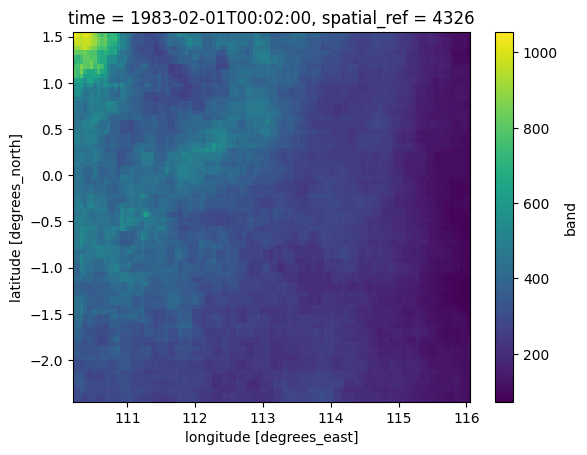

In [21]:
new_r1h.isel(time=2).plot.imshow()
plt.show

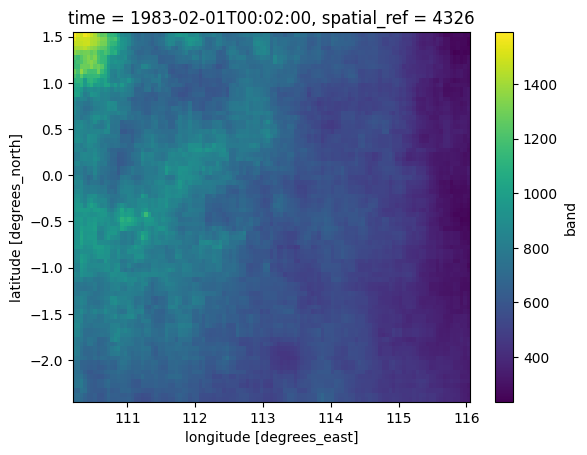

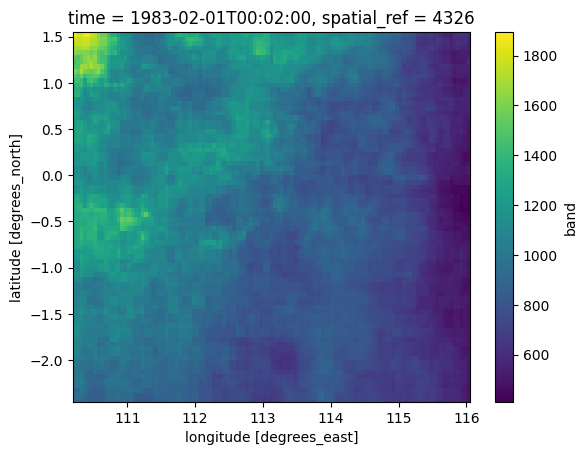

In [22]:
new_r2h.isel(time=2).plot.imshow()
plt.show()
new_r3h.isel(time=2).plot.imshow()

# ECMWF

In [ ]:
path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/0{start_season-1}/01'

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":70, "ensemble":-1}, engine='zarr')
ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 
ds_issue = ds_issue.tp.load()

da_issue= ds_issue.groupby("time.year").apply(lambda da :  da.diff(dim='time', n=1))
# da_issue = da_issue.mean("ensemble") #Output 1 ensemble
# #da_issue = da_issue.diff(dim='time', n=1).fillna(0)  # Non cumulative

In [ ]:
# DONT RUN only for dekad!!!!!


from hdc.algo.accessors import Dekad
from odc import stac
import datetime

def dekad_to_date(dekad):
    dek = str(dekad)
    DEKAD = {'1':1,'2':11,'3':21}
    
    return np.datetime64(datetime.date(int(dek[:4]), int(dek[4:6]), DEKAD[dek[-1]]))



start_date = datetime.datetime(1983,1,1)
end_date = datetime.datetime(2023,6,21)

da_issue_dek = da_issue.sel(time=slice(start_date, end_date))
da_issue_dek = da_issue_dek.where(da_issue_dek.time.dt.month.isin(range(start_season, end_season)), drop=True)
da_issue_dek = da_issue_dek.assign_coords(dek=Dekad(da_issue_dek.time).label)
da_issue_dek = da_issue_dek.groupby(da_issue_dek.dek).sum()

time = [dekad_to_date(dekad.values) for dekad in da_issue_dek.dek]
da_issue_dek['dek'] = time

da_issue  =da_issue_dek.rename(dek='time')


In [ ]:
tp = np.random.rand(615*rep,4,6)

for i in range(da_issue.time.shape[0]):
    for j in range(rep):
        tp [i*rep+j] = da_issue.isel(time=i, ensemble=j)
        
# Create an Xarray DataArray
new_da = xr.DataArray(tp, coords={'time': np.arange(615*rep),
                               'latitude': np.arange(4),
                               'longitude': np.arange(6)},
                    dims=['time', 'latitude', 'longitude'],
                    name='tp')
    

new_da['time'] = modified_dates
new_da['latitude'] = da_issue['latitude']
new_da['longitude'] = da_issue['longitude']


In [40]:
new_da

<xarray.DataArray 'tp' (time: 3075, latitude: 4, longitude: 6)>
array([[[1.03973389e-01, 6.85729980e-02, 6.10046387e-02, 5.89599609e-02,
         3.42102051e-02, 1.12304688e-02],
        [6.54296875e-02, 7.17163086e-02, 8.22143555e-02, 5.85937500e-02,
         3.23181152e-02, 1.17492676e-02],
        [1.04339600e-01, 8.61816406e-02, 7.44934082e-02, 4.28466797e-02,
         1.86767578e-02, 6.56127930e-03],
        [9.36584473e-02, 6.46667480e-02, 5.12695312e-02, 2.75573730e-02,
         1.57165527e-02, 8.36181641e-03]],

       [[1.48834229e-01, 1.06964111e-01, 1.09161377e-01, 1.29577637e-01,
         6.81457520e-02, 3.28063965e-02],
        [1.05590820e-01, 9.84802246e-02, 1.42822266e-01, 1.02355957e-01,
         6.82983398e-02, 5.72814941e-02],
        [1.60766602e-01, 1.12854004e-01, 1.36352539e-01, 9.72290039e-02,
         1.00372314e-01, 8.48693848e-02],
        [1.74285889e-01, 1.69586182e-01, 1.54541016e-01, 1.19140625e-01,
         1.50482178e-01, 1.14105225e-01]],

       [[2.15972900e-01, 1.10260010e-01, 1.00463867e-01, 7.98339844e-02,
         3.84216309e-02, 2.37121582e-02],
...
        [5.12695312e-03, 8.17871094e-03, 1.69067383e-02, 1.97753906e-02,
         1.76391602e-02, 1.14135742e-02]],

       [[1.08642578e-02, 1.27563477e-02, 1.58081055e-02, 2.03857422e-02,
         3.42407227e-02, 1.18408203e-02],
        [8.23974609e-03, 1.28173828e-02, 2.83203125e-02, 3.04565430e-02,
         2.44140625e-02, 1.30615234e-02],
        [3.90625000e-03, 5.92041016e-03, 2.99682617e-02, 2.14843750e-02,
         1.01318359e-02, 4.88281250e-03],
        [4.57763672e-03, 7.08007812e-03, 1.50146484e-02, 4.51660156e-03,
         4.69970703e-03, 3.29589844e-03]],

       [[6.10351562e-05, 6.10351562e-05, 6.10351562e-05, 1.83105469e-04,
         1.83105469e-04, 6.10351562e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.10351562e-05,
         3.66210938e-04, 7.32421875e-04],
        [0.00000000e+00, 0.00000000e+00, 3.05175781e-04, 1.15966797e-03,
         1.28173828e-03, 4.88281250e-04],
        [3.66210938e-04, 7.32421875e-04, 1.34277344e-03, 1.40380859e-03,
         1.58691406e-03, 1.22070312e-03]]])
Coordinates:
  * time         (time) datetime64[ns] 1983-02-01 ... 2023-06-21T00:04:00
  * latitude     (latitude) float64 1.5 0.5 -0.5 -1.5
  * longitude    (longitude) float64 110.5 111.5 112.5 113.5 114.5 115.5
    spatial_ref  int32 4326

In [41]:
window_size = 3  # Number of previous dates to include in the sum
da_issue_agg = new_da.rolling(time=window_size, min_periods=window_size).sum()
# da_issue_agg = da_issue.isel(time=slice(window_size - 1, None))
da_issue_agg =  da_issue_agg.combine_first(new_da)
new_da_agg = da_issue_agg

In [42]:
# da_monthly_sum = da_issue.resample(time='1M').sum()
# da_monthly_sum_season  = da_monthly_sum.sel(time=(da_monthly_sum['time.month'] >= start_season) & (da_monthly_sum['time.month'] <= end_season), drop=True) 
da_monthly_sum_season_near = new_da_agg.rio.write_crs(ds_issue.rio.crs).rio.reproject(r1h.rio.crs, 
                                                             resolution=(-0.05,0.05), 
                                                             resampling=rasterio.enums.Resampling.nearest)

da_monthly_sum_season_near = da_monthly_sum_season_near.rename({'y': 'latitude', 'x': 'longitude'})
da_monthly_sum_season_near = da_monthly_sum_season_near 

r1h_resample = new_r1h.sel(latitude = slice(1.5, -1.5 ), longitude = slice(110.5, 115.5))
r2h_resample = new_r2h.sel(latitude = slice(1.5, -1.5 ), longitude = slice(110.5, 115.5))
r3h_resample = new_r3h.sel(latitude = slice(1.5, -1.5 ), longitude = slice(110.5, 115.5))
da_monthly_sum_season_near_resample =da_monthly_sum_season_near.sel(latitude = r1h_resample.latitude.values, longitude= r1h_resample.longitude.values, method = "nearest")


latitude_size, longitude_size = 32,32


In [64]:

new_r1h = r1h_resample.isel(latitude=slice(0,latitude_size), longitude=slice(longitude_size, longitude_size+32))
new_r2h = r2h_resample.isel(latitude=slice(0,latitude_size), longitude=slice(longitude_size, longitude_size+32))
new_r3h = r3h_resample.isel(latitude=slice(0,latitude_size), longitude=slice(longitude_size, longitude_size+32))
da_monthly_sum_season_near  = da_monthly_sum_season_near_resample.isel(latitude=slice(0, latitude_size), longitude=slice(longitude_size, longitude_size+32))
# da_monthly_sum_season_near.to_netcdf(f'Data/Downscaling/Rainfall/Jordan/data/da_monthly_sum_season_near_01.nc')

# rfh = rfh.sel(time=(rfh['time.month'] >= start_season) & (rfh['time.month'] <= end_season), drop=True) 
# scaling_factors = rfh.max() / da_monthly_sum_season_near.max()
scaling_factors = 1e3
print(scaling_factors)
forecast = da_monthly_sum_season_near*scaling_factors

1000.0


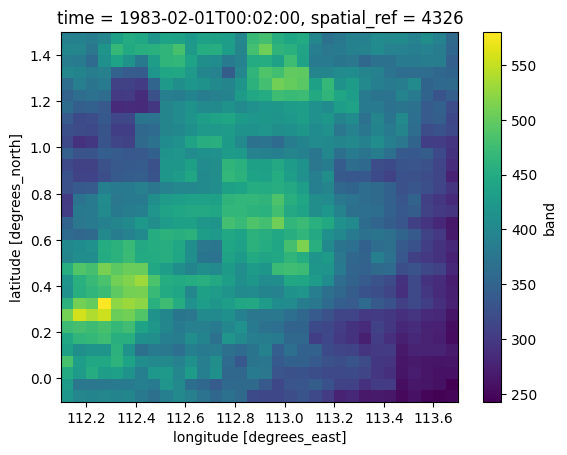

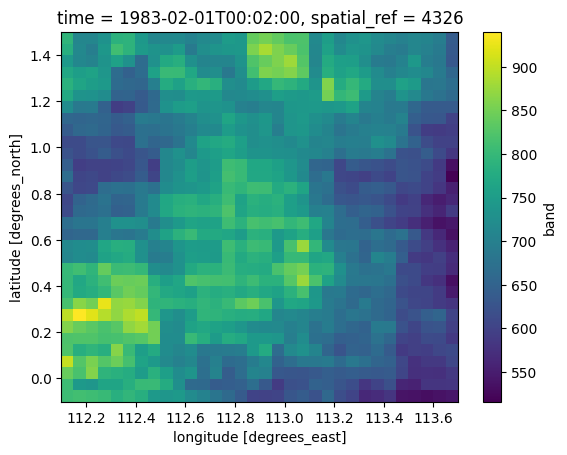

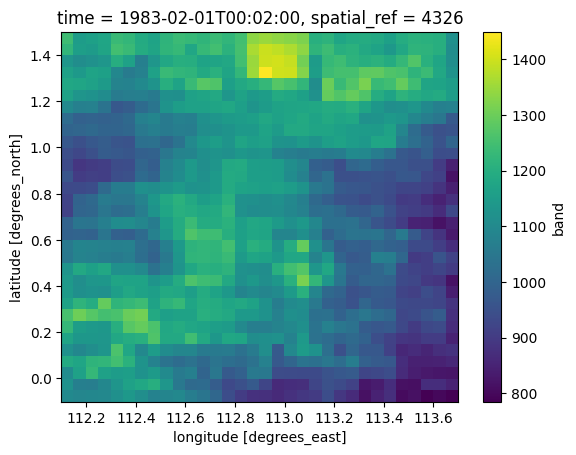

In [65]:
new_r1h.isel(time=2).plot.imshow()
plt.show()
new_r2h.isel(time=2).plot.imshow()
plt.show()
new_r3h.isel(time=2).plot.imshow()


In [67]:
forecast.to_netcdf(f'Data/Downscaling/Rainfall/{region}_more/data/forecast.nc')
new_r1h.to_netcdf(f'Data/Downscaling/Rainfall/{region}_more/data/r1h.nc')
new_r2h.to_netcdf(f'Data/Downscaling/Rainfall/{region}_more/data/r2h.nc')
new_r3h.to_netcdf(f'Data/Downscaling/Rainfall/{region}_more/data/r3h.nc')


# LTA

In [68]:
forecast_near = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}_more/data/forecast.nc')
# forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
rfh = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}_more/data/r1h.nc')

rfh_lta = rfh.sel(time=slice("1983-02-28","2018-05-31"))
rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
rfh_lta = rfh_lta.sel(strftime=rfh.time.dt.strftime("%m-%d"))
rfh_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}_more/data/r1h_lta.nc')

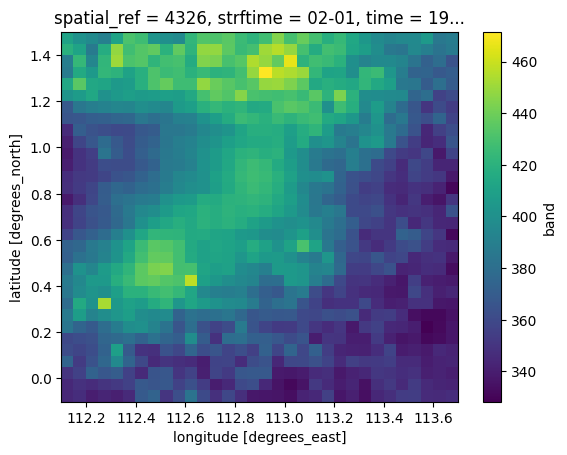

In [69]:
rfh_lta.isel(time=0)['band'].plot.imshow()

In [70]:
# forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
rfh = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}_more/data/r2h.nc')

rfh_lta = rfh.sel(time=slice("1983-02-28","2018-05-31"))
rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
rfh_lta = rfh_lta.sel(strftime=rfh.time.dt.strftime("%m-%d"))
rfh_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}_more/data/r2h_lta.nc')

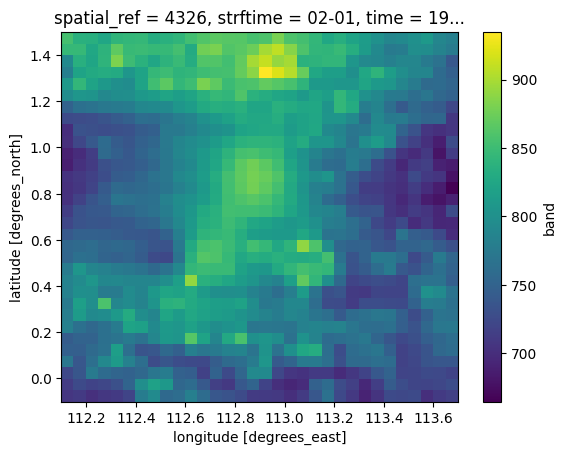

In [71]:
rfh_lta.isel(time=0)['band'].plot.imshow()

In [72]:
# forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
rfh = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}_more/data/r3h.nc')

rfh_lta = rfh.sel(time=slice("1983-02-28","2018-05-31"))
rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
rfh_lta = rfh_lta.sel(strftime=rfh.time.dt.strftime("%m-%d"))
rfh_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}_more/data/r3h_lta.nc')

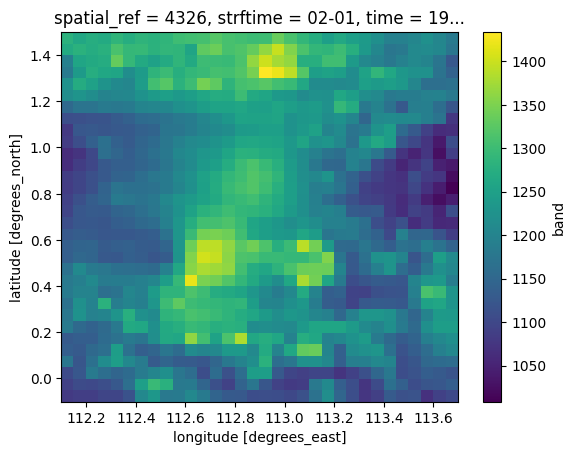

In [73]:
rfh_lta.isel(time=0)['band'].plot.imshow()

In [74]:
rfh_lta

<xarray.Dataset>
Dimensions:      (latitude: 32, longitude: 32, time: 3075)
Coordinates:
  * latitude     (latitude) float64 1.475 1.425 1.375 ... 0.025 -0.025 -0.075
  * longitude    (longitude) float64 112.1 112.2 112.2 ... 113.6 113.6 113.7
    spatial_ref  int32 4326
    strftime     (time) object '02-01' '02-01' '02-01' ... '06-21' '06-21'
  * time         (time) datetime64[ns] 1983-02-01 ... 2023-06-21T00:04:00
Data variables:
    band         (time, latitude, longitude) float64 1.282e+03 ... 963.4

In [69]:
vars(np.load('Data/Downscaling/Rainfall/Indonesia_more/data_npz/train/1983_00_inp.npz'))

{'_files': ['rfh_lta.npy', 'forecast.npy', 'r2h.npy', 'r3h.npy'],
 'files': ['rfh_lta', 'forecast', 'r2h', 'r3h'],
 'allow_pickle': False,
 'max_header_size': 10000,
 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True},
 'zip': None,
 'f': None,
 'fid': None}

INFO:distributed.utils_perf:full garbage collection released 42.99 MiB from 49721 reference cycles (threshold: 9.54 MiB)


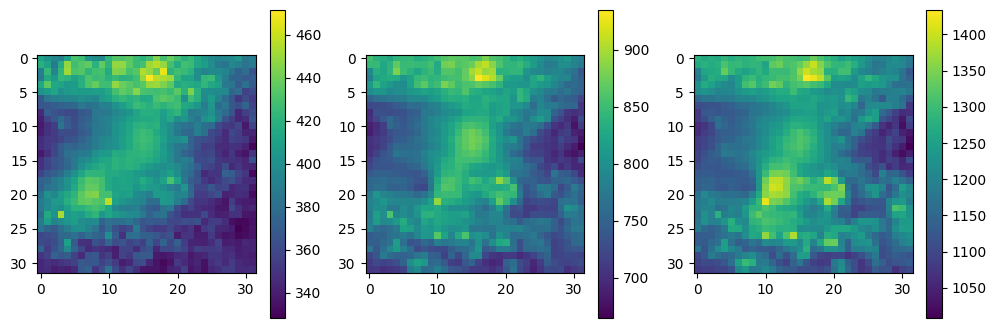

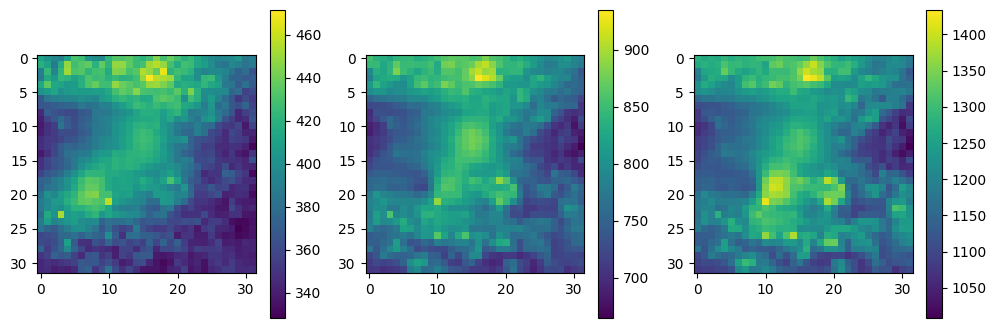

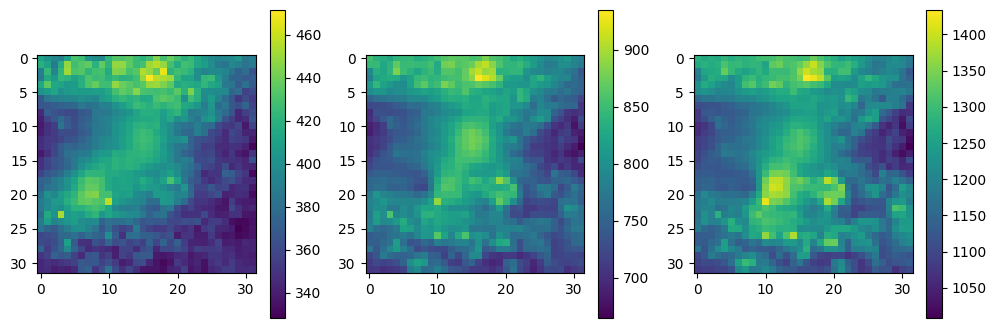

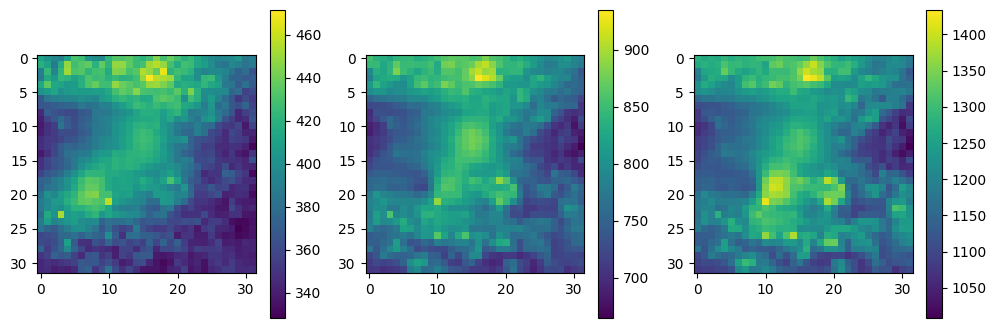

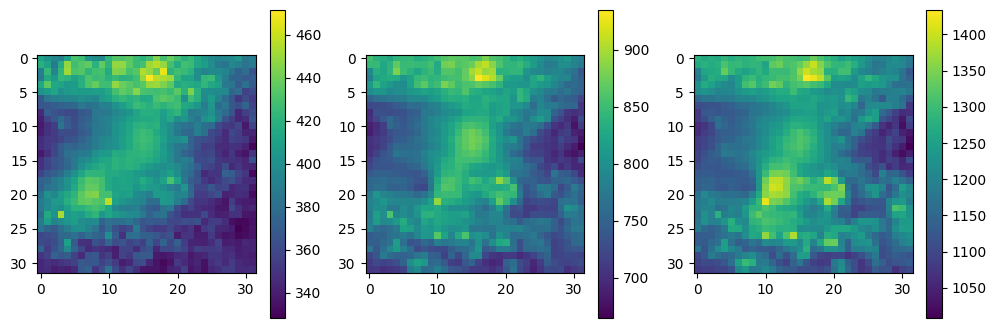

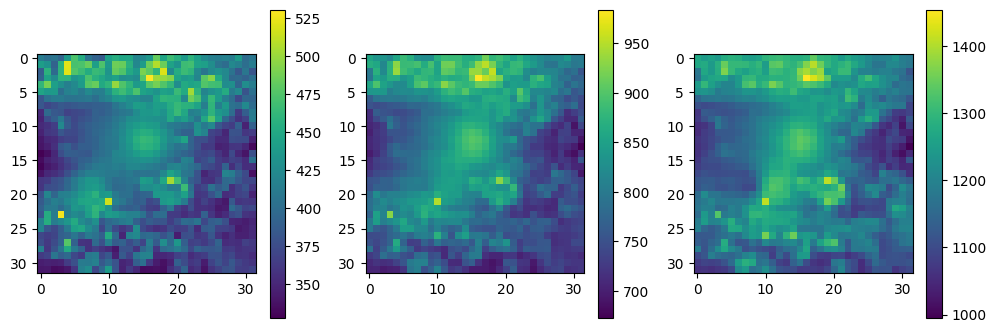

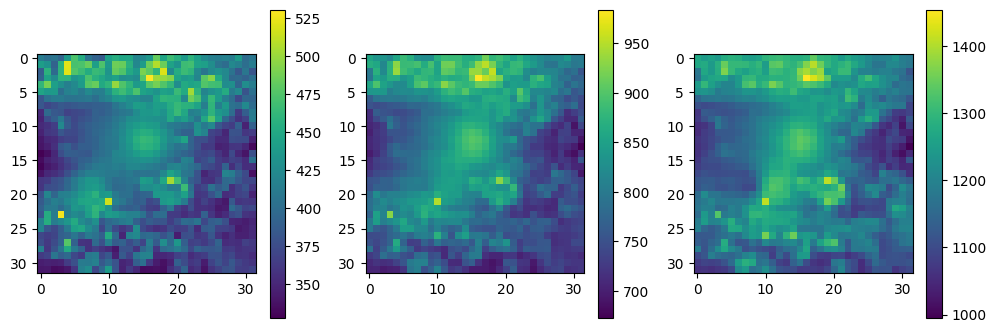

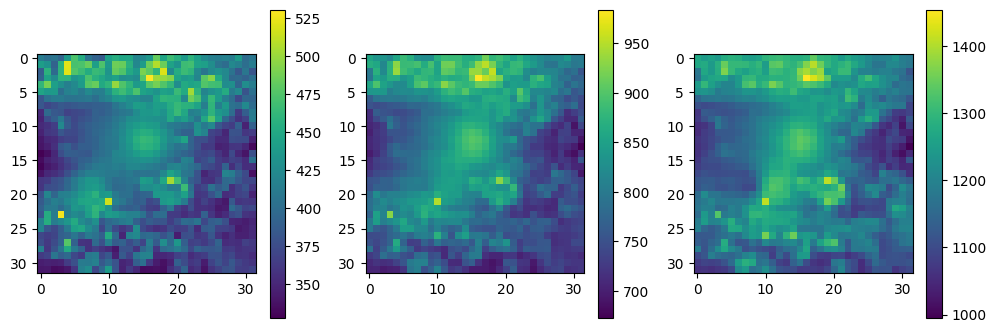

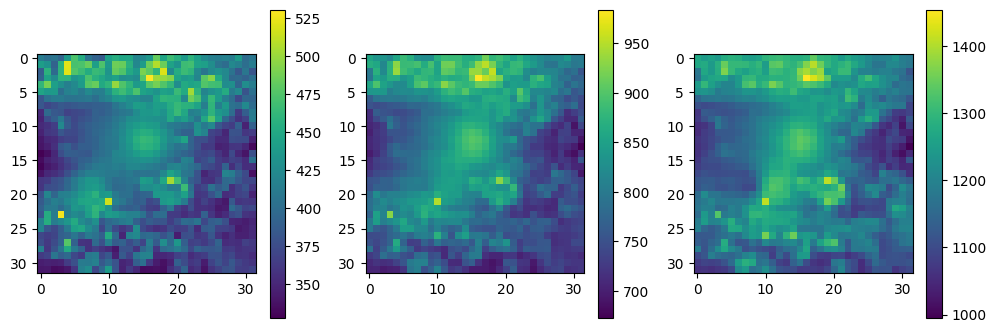

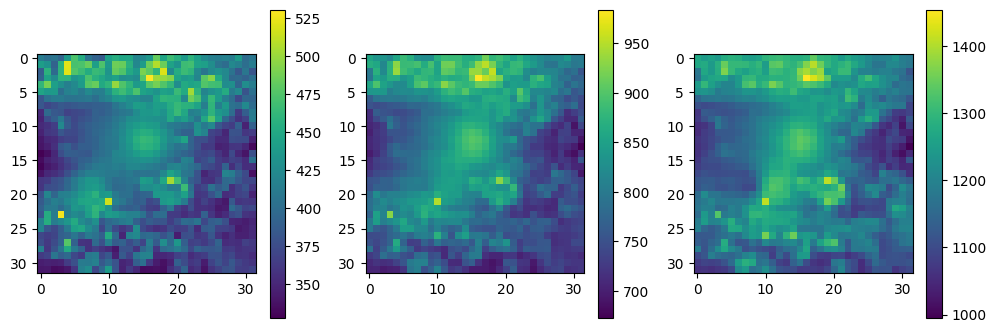

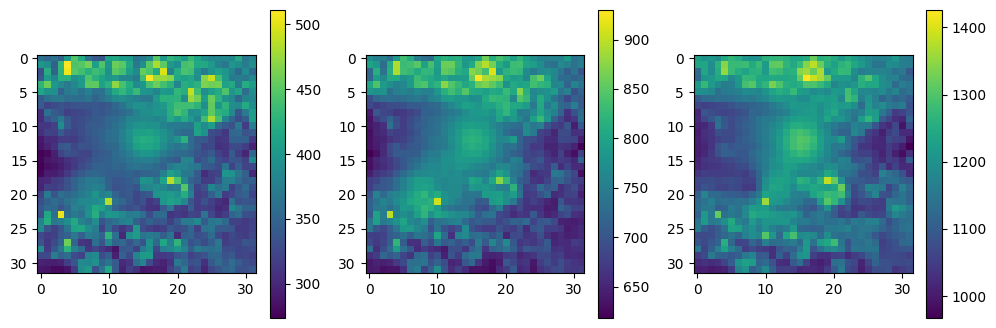

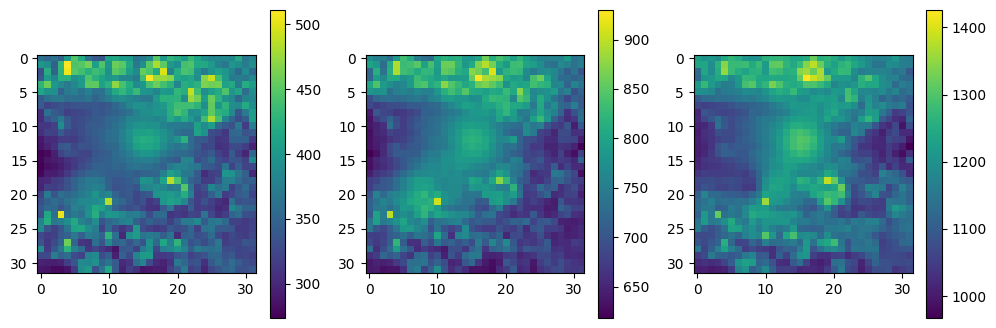

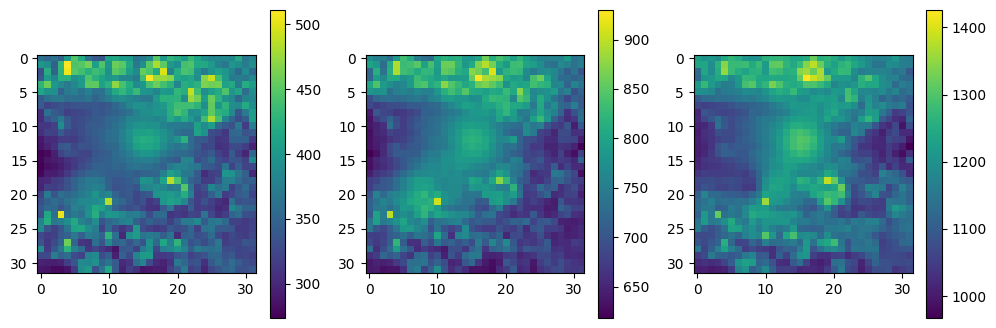

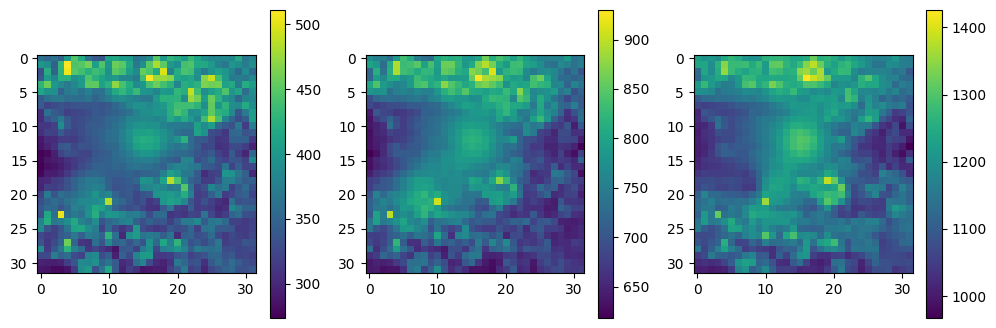

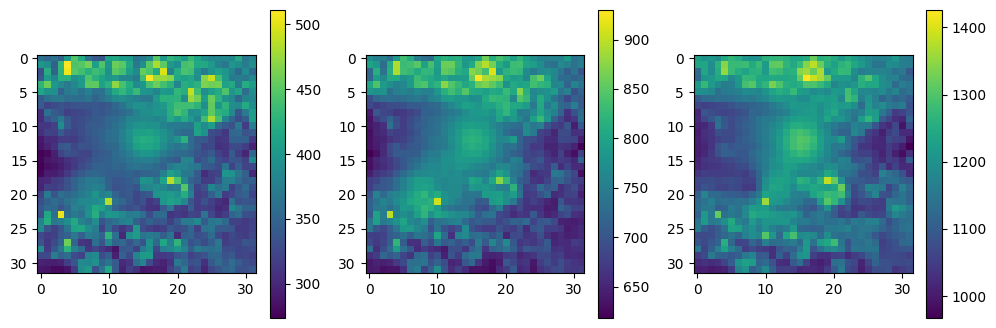

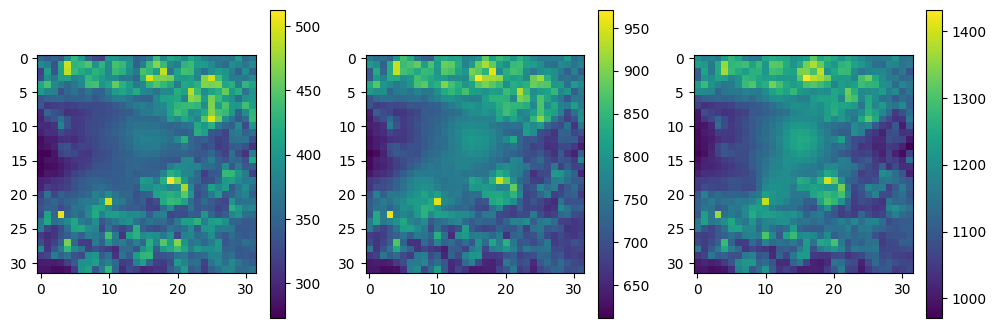

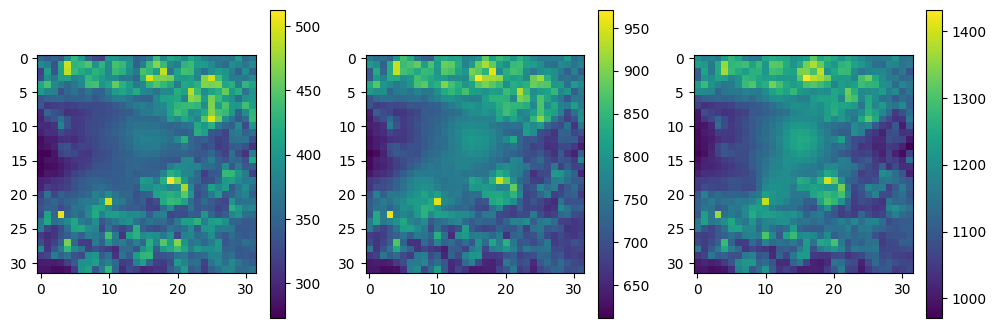

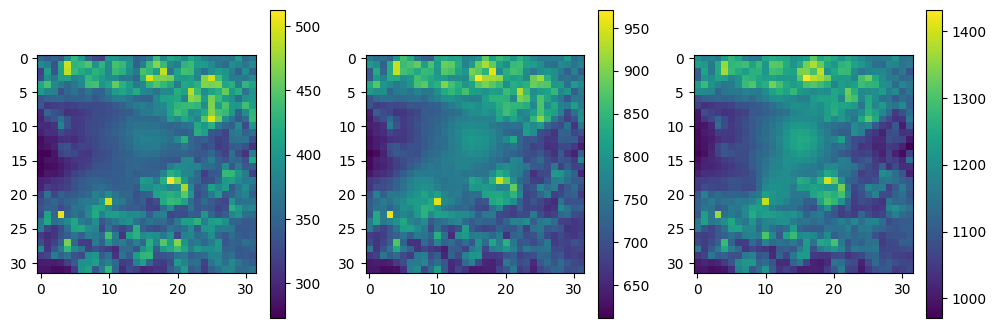

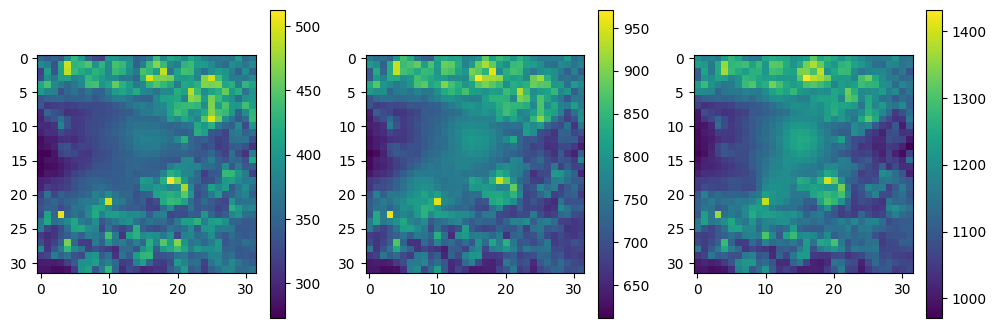

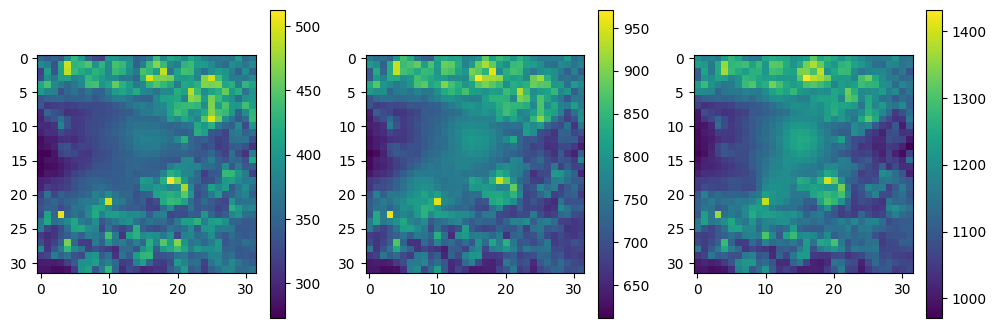

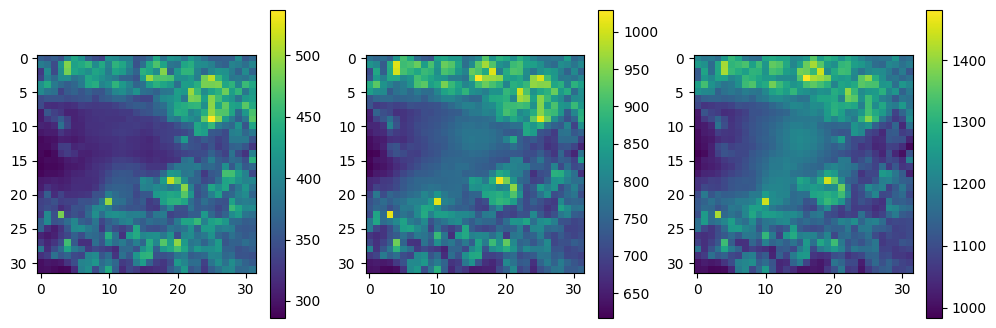

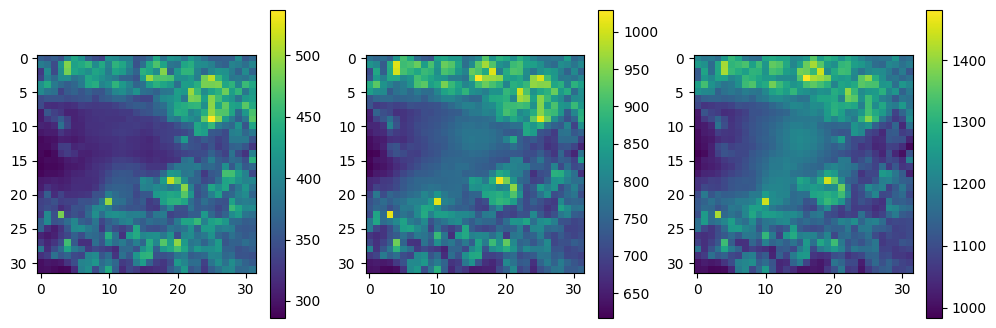

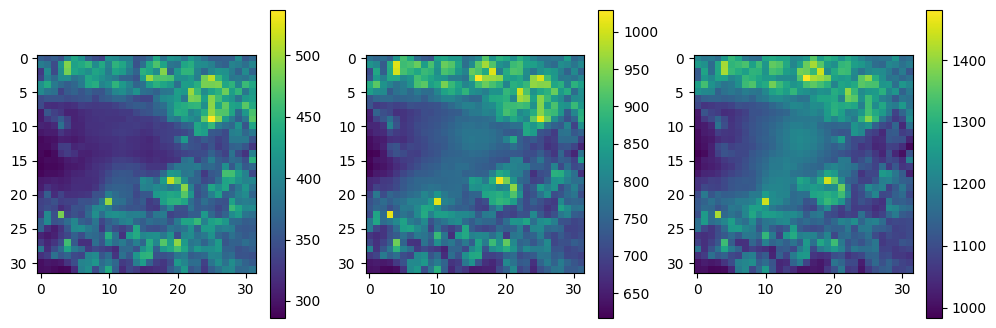

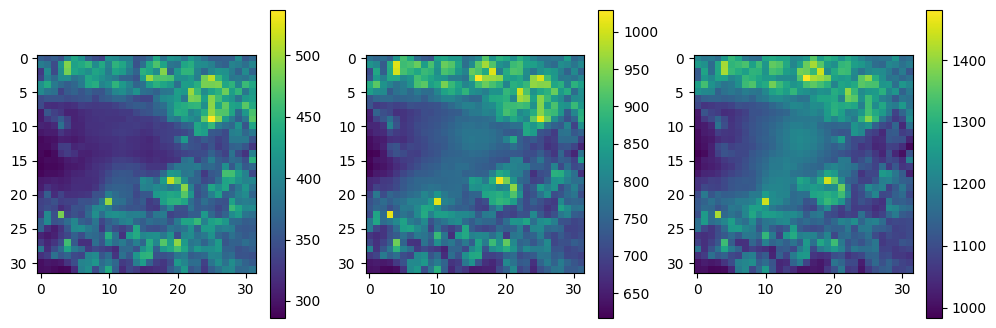

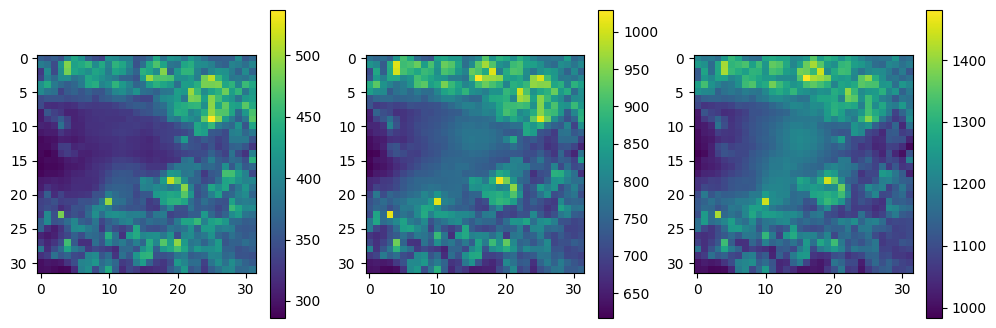

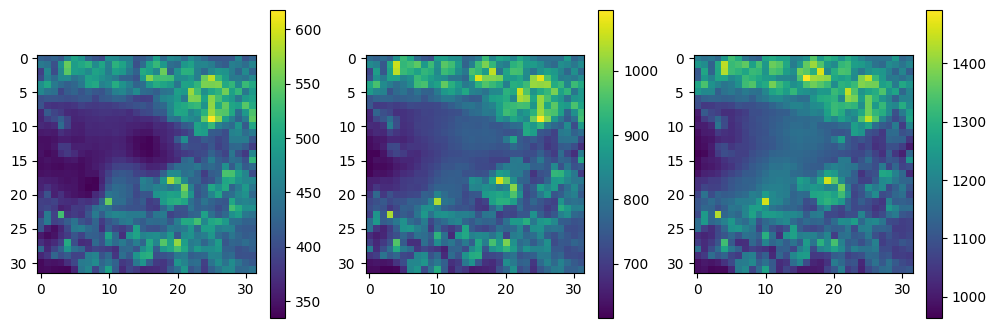

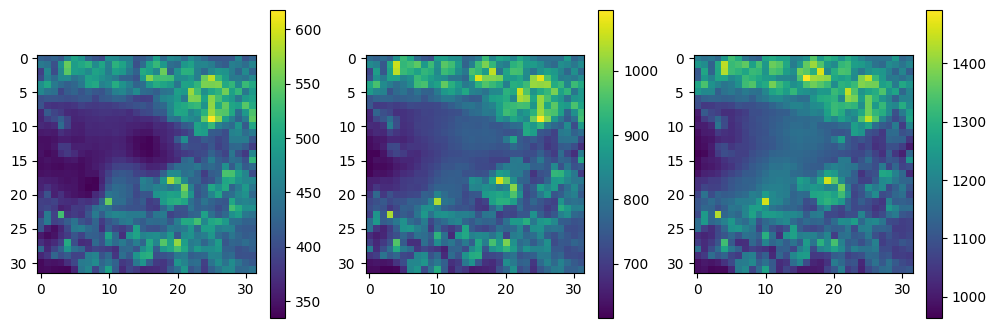

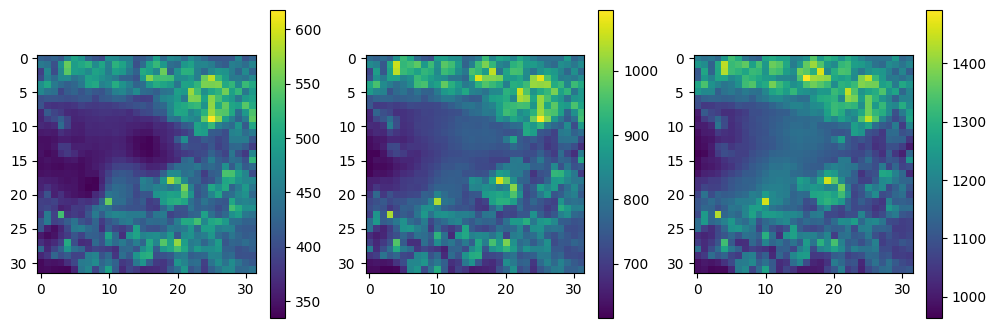

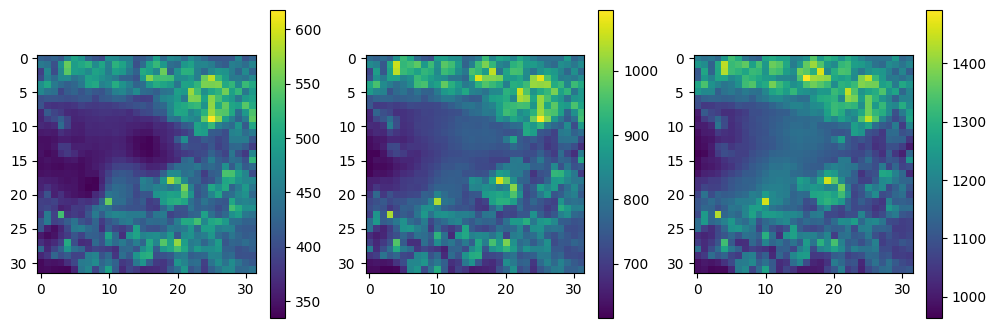

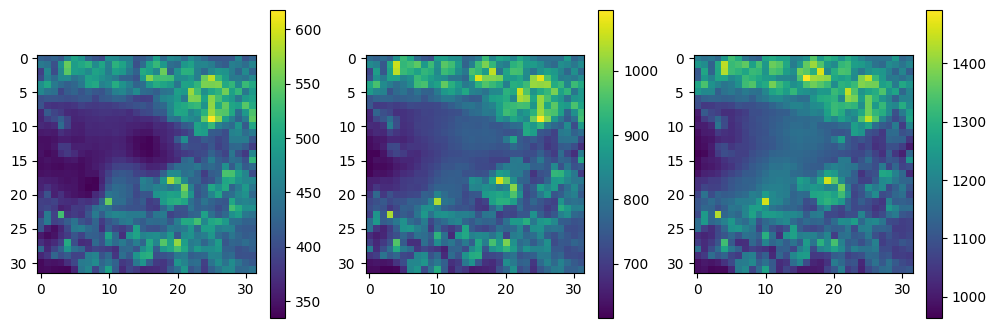

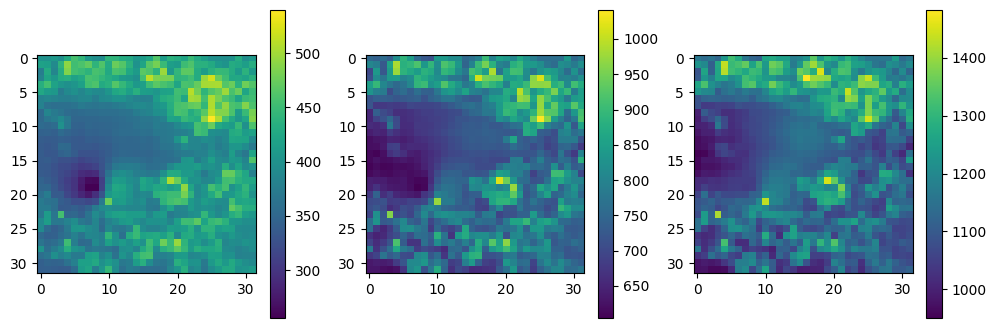

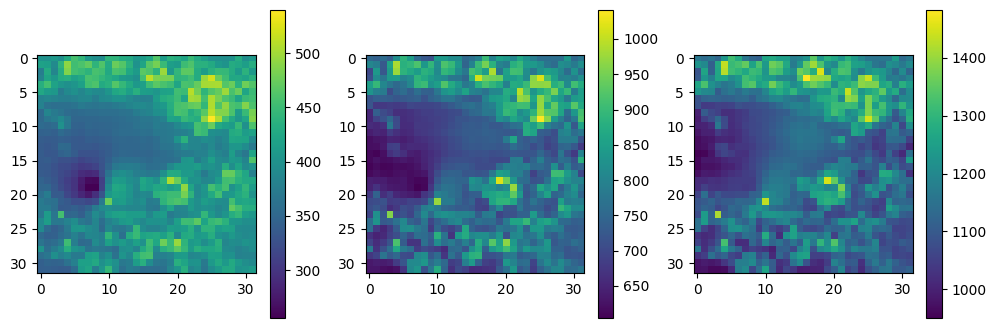

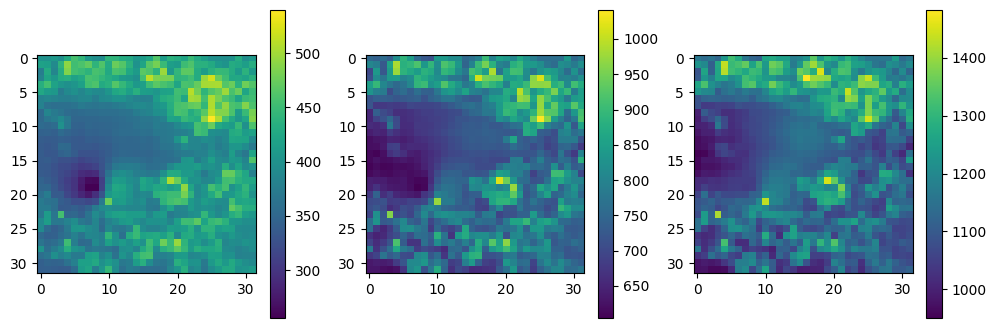

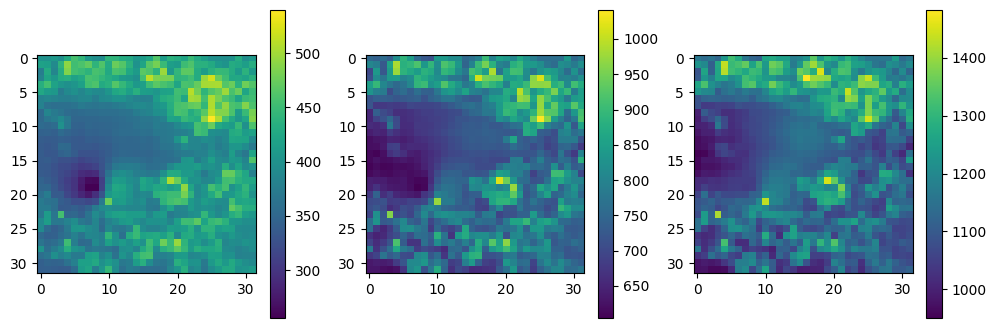

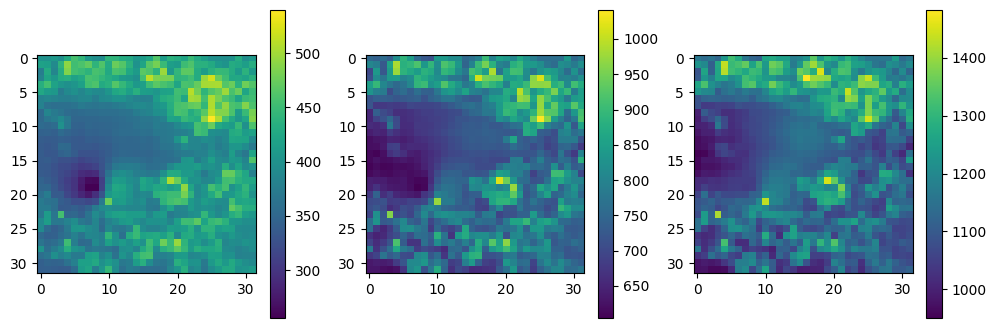

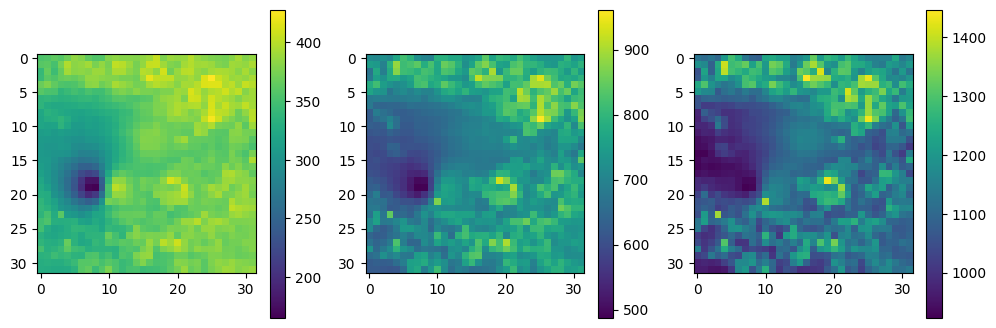

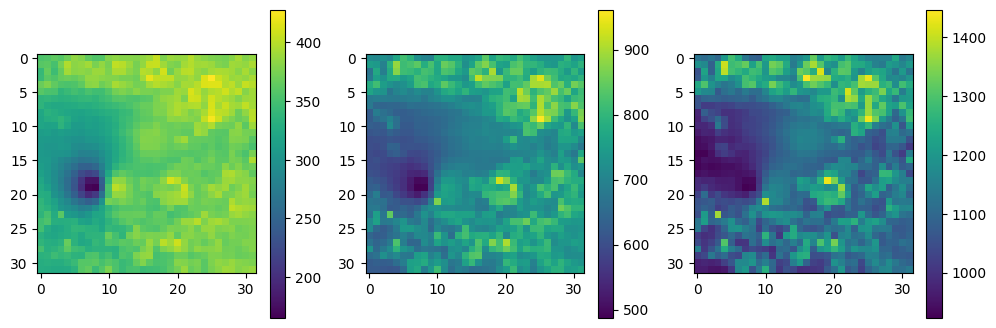

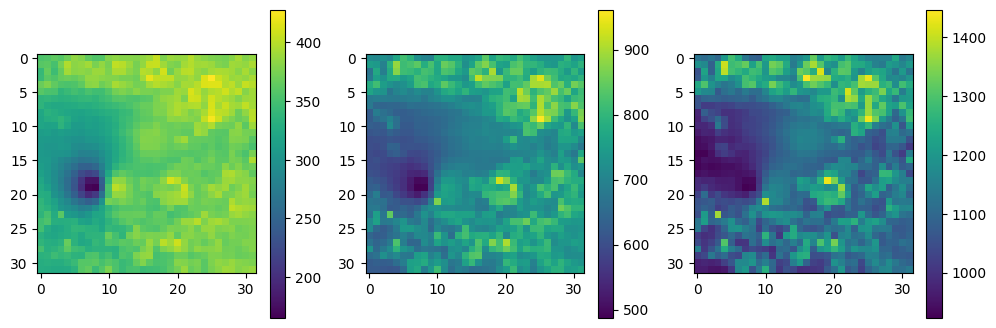

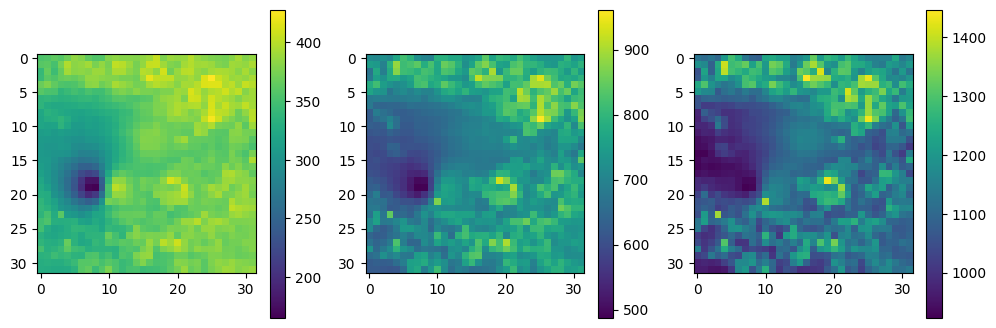

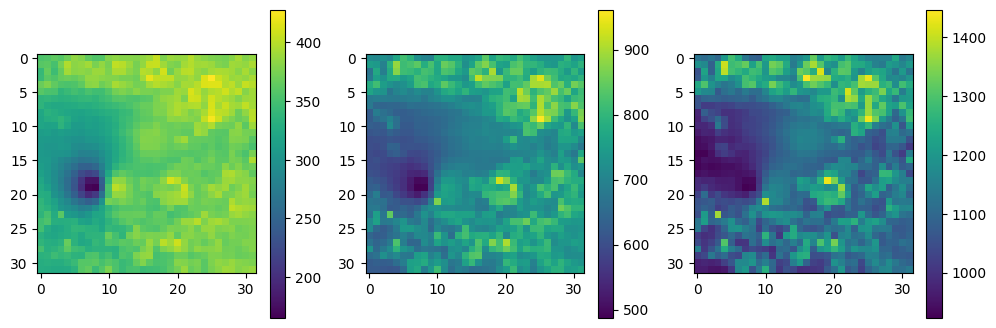

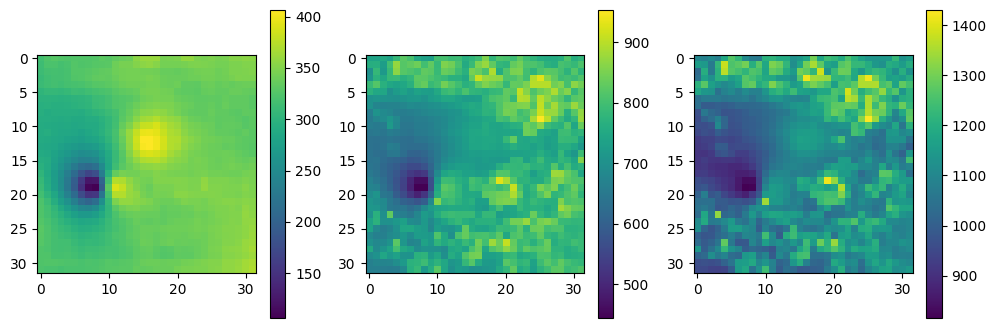

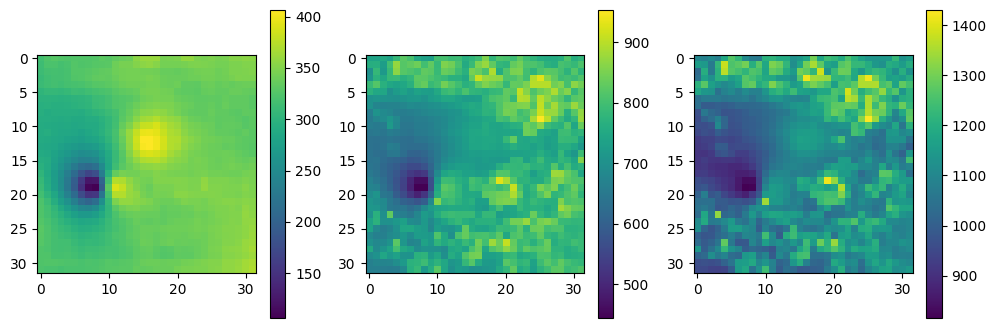

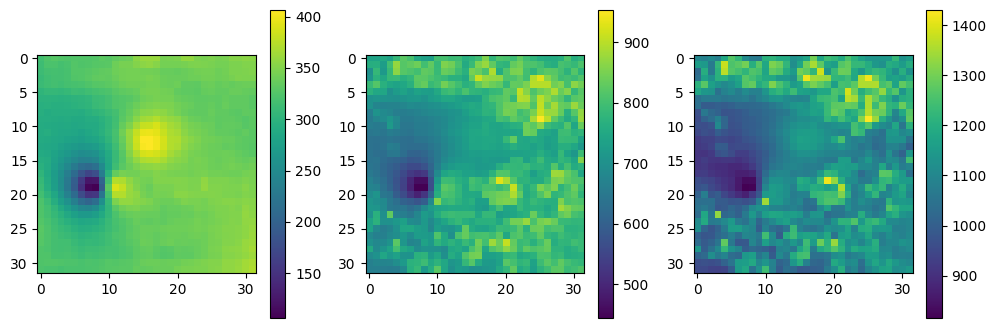

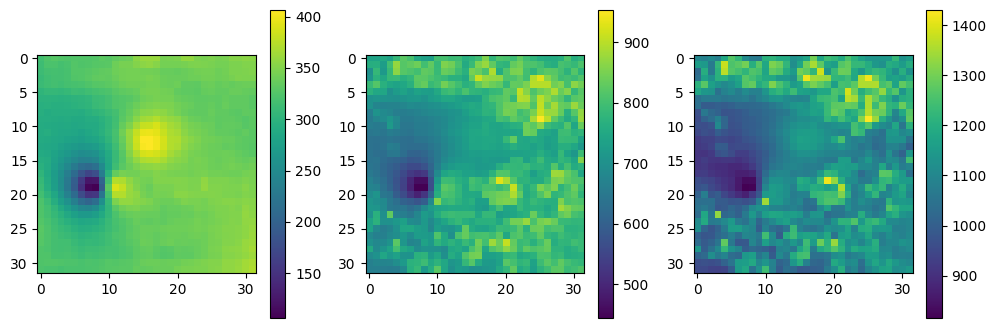

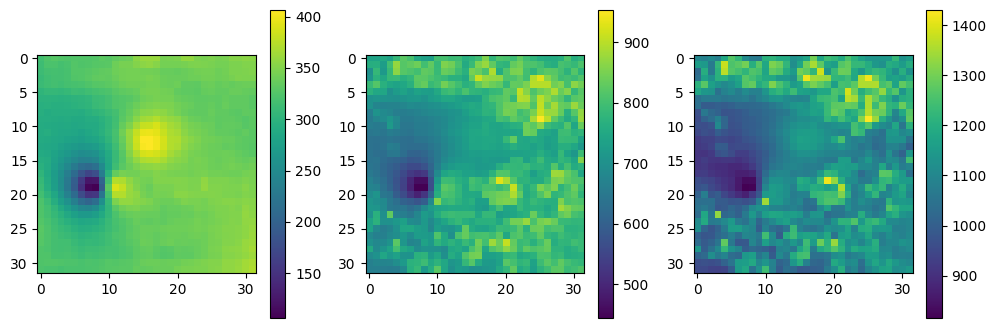

INFO:distributed.core:Connection to tcp://127.0.0.1:57260 has been closed.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:46387', name: 2, status: running, memory: 0, processing: 0>
INFO:distributed.core:Removing comms to tcp://127.0.0.1:46387
INFO:distributed.core:Connection to tcp://127.0.0.1:57222 has been closed.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:34113', name: 1, status: running, memory: 0, processing: 0>
INFO:distributed.core:Removing comms to tcp://127.0.0.1:34113
INFO:distributed.core:Connection to tcp://127.0.0.1:57244 has been closed.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:44401', name: 0, status: running, memory: 0, processing: 0>
INFO:distributed.core:Removing comms to tcp://127.0.0.1:44401
INFO:distributed.batched:Batched Comm Closed <TCP (closed) Scheduler connection to worker local=tcp://127.0.0.1:38123 remote=tcp://127.0.0.1:57244>
Traceback (most recent call last):
  File "/envs

In [76]:
data = np.load('Data/Downscaling/Rainfall/Indonesia2_more/data_npz/test/2022_00_inp.npz')
for t in range(45):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    # Plot the data in each subplot
    im1 = axes[0].imshow(data['rfh_lta'][t,0])
    im2 = axes[1].imshow(data['r2h'][t,0])
    im3 = axes[2].imshow(data['r3h'][t,0])
    
    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)
    
    plt.show()
